# TODO:

<ol>
    <li>
            Markdown írása, közben kód átültetése, kipofozása (KEZDŐ JÁTÉKOSNÁL TREFF 2!!!)
    </li>
    <li>
        Error check:
        <ol>
            <li>
                Fut-e még
            </li>
            <li>
                Stratégiák tudják-e kezelni, ha elsők és/vagy utolsók
            </li>
            <li>
                Futásidő jó-e, bemutatható-e az egész Notebook 
            </li>
        </ol>
    </li>
</ol>

# Előadás haditerv:

<ol>
    <li>
        Játékszabályok, miért (neuháló a játékban, mint bot) (3p + 1p) <b>Done</b>
    </li>
    <li>
        Négy stratégia, amit kitaláltunk (4p)
    </li>
    <li>
        Pl. egy játék, ahogy a pontok nőnek, billentyűleütésre vár körök előtt
        <br />Táblázatba, ha lehet (elég félfancy) (2p)
    </li>
    <li>
        Stratégiák közül melyik lehet jó (2p)
    </li>
    <li>
        Egymás elleni szűrések eredményei (horizontal bar chart)
        <br />Három példa (3p)
        <br />
    </li>
</ol>

# Motiváció

<ul>
    <li>
        Fekete Macska, mint játék, kutatási terület ML-ben: hogyan lehetne egy neurális hálót betanítani úgy, hogy az valódi ellenfélnek tűnjön számunkra, amikor játszunk ellene, és ne lehessen a szokásos módon kicselezni.
    </li>
    <li>
        Ehhez ugyebár generálni kellene rengeteg játékot, játékállást, amivel a háló tanítható lenne...
    </li>
    <li>
        Vagy alkotunk egy botot, ami "elég jól" játszik — azaz van egy elég jó stratégiája, és ez ellen játszatni a hálót. Ha több jó stratégia is van, akkor a háló jobban tud tanulni.
    </li>
    <li>
        Ehhez viszont kellenek jó stratégiák — mi 4 stratégiát találtunk ki és kezdtünk el elemezni, hogy melyik lehetne jó erre a célra.
    </li>
</ul>

# Játékszabályok

<ul>
    <li>
        A játék kezdetén a 4 játékosnak kiosztjuk az 52 lapot, mindenki kap 13-at.
        <br /> (5, 6 játékosra is átszabható a játék, de hagyományosan 4-en játsszák)
    </li>
    <li>
        Addig mennek a körök, amíg valaki el nem éri a 100 pontot. Ha valaki elérte a 100 pontot, akkor az(ok) nyernek, aki(k)nek a legkevesebb pontja van.
    </li>
    <li>
        Az első kör elején mindenki kiválaszt 3 lapot, amit átad a tőle <i>jobbra</i> levő játékosnak,
        <br /> a második kör elején ezt a 3 lapot mindenki a tőle <i>balra</i> levő játékosnak,
        <br /> a harmadik kör elején az átadás a <i>szemben levő</i> játékosok között történik,
        <br /> a negyedik körben <i>nincs</i> átadás.
        <br /> újra a <i>jobbra</i> ülő játékosnak adjuk át a lapokat, és így tovább
    </li>
    <li>
        Az a játékos nyit, akinél a treff kettes van, ő bedob középre egy lapot (ez lesz a dekk). Ezután mindenki olyan színű lapot köteles dobni, mint az elsőnek bedobott lap. Ha nem tud, akkor bármit dobhat. Ez alól egy kivétel van: az első körben pontot érő lapokat nem szabad szúrni. Mindig az viszi a 4 bedobott lapot, akinek a kezdő színben a legnagyobb értékű lapja van.
    </li>
    <li>
        A pontot érő lapok a <b>kőr</b> színű lapok, és a <b>pikk dáma</b>. A kőrök egy pontot érnek, a pikk dáma 13-at.
    </li>
    <li>
        Addig ismételik ezt a játékosok, amíg mindenkinek el nem fogy a lapja.
    </li>
    <li>
        A kör végén mindenki megnézi, hány pontnyi lapot gyűjött be, és ennyi pontot kap. Ha az összes pontot érő lapot egy játékos gyűjtötte be, akkor ő 0 pontot kap, és mindenki más 26-ot.
    </li>
    <li>
        Ha még senki se gyűjtött össze 100 pontot, akkor a pakli újra ki van osztva, és új kör kezdődik.
    </li>
</ul>

In [1]:
#Szükséges importálások, segédfüggvények

import random as rd
import matplotlib.pyplot as plt
import numpy as np

card_colors = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
card_numbers = list(range(2,11)) + ['J','Q','K','A']
dangerous_cards = [('Spades', 'Q'), ('Hearts', 2), ('Hearts', 3), ('Hearts', 4),
                   ('Hearts', 5), ('Hearts', 6), ('Hearts', 7), ('Hearts', 8), ('Hearts', 9), ('Hearts', 10),
                   ('Hearts', 'J'), ('Hearts', 'Q'), ('Hearts', 'K'), ('Hearts', 'A')]

In [2]:
#Segédfüggvények

def bigger(v1, v2):
    '''
        Eldötni, két lapérték közül melyik a nagyobb
        Minimumkeresés segítése miatt saját indexlistát használ
    '''
    indexlist = list(range(1,11)) + ['J','Q','K','A']
    
    #Nem fog olyannal találkozni, ahol v1 és v2 egy helyen van
    if indexlist.index(v1) > indexlist.index(v2):
        return v1
    else:
        return v2
    
def calculate_point_value(stack):
    '''
        Kiszámolja a dekkben össszegyűjtött lapok pontértékét
        Pikk dáma 13-at ér, minden Kőr lap pedig 1-et
    '''
    value = 0
    for item in stack:
        if item[0] == 'Spades' and item[1] == 'Q':
            value = value + 13
        else:
            value = value + 1
            
    return value

def deal():
    '''
        Kiosztja a lapokat
    '''
    deck = [(color, number) for color in card_colors for number in card_numbers]
    hands = [[],[],[],[]]

    while len(deck) > 0:
        for hand in hands:
            rx = rd.randint(0, len(deck) - 1)
            card = deck[rx]
            hand.append(card)
            deck.remove(card)
    
    return hands

def pass_cards(rounds):
    '''
        Attól függően, hogy hanyadik körről van szó, levezényli a botok közt a lapátadásokat
    '''
    #Kicsit csúnya, hogy if, elif, de 3.7-es Python kernel valamiért nem szereti a match-et, csak 3.8-as kerneltől van
    if rounds % 4 == 1:
        #Minden első körben jobbra megy a lapátadás. Jobbra haladva van a számozás, így ez egyszerű.
        cards_bot1 = bot4.pass_cards()
        cards_bot2 = bot1.pass_cards()
        cards_bot3 = bot2.pass_cards()
        cards_bot4 = bot3.pass_cards()
         
        bot1.receive_cards(cards_bot1)
        bot2.receive_cards(cards_bot2)
        bot3.receive_cards(cards_bot3)
        bot4.receive_cards(cards_bot4)
    elif rounds % 4 == 2:
        #Minden második körben balra megy az átadás, a számozás eszerint van átírva.
        cards_bot1 = bot2.pass_cards()
        cards_bot2 = bot3.pass_cards()
        cards_bot3 = bot4.pass_cards()
        cards_bot4 = bot1.pass_cards()
            
        bot1.receive_cards(cards_bot1)
        bot2.receive_cards(cards_bot2)
        bot3.receive_cards(cards_bot3)
        bot4.receive_cards(cards_bot4)    
    elif rounds % 4 == 3:
        #Minden harmadik körben szembe egy az átadás, a számozás eszerint van átírva.
        cards_bot1 = bot3.pass_cards()
        cards_bot2 = bot4.pass_cards()
        cards_bot3 = bot1.pass_cards()
        cards_bot4 = bot2.pass_cards()
           
        bot1.receive_cards(cards_bot1)
        bot2.receive_cards(cards_bot2)
        bot3.receive_cards(cards_bot3)
        bot4.receive_cards(cards_bot4)
    #Minden negyedik körben el van hagyva a lapátadás, ez lenne az else ág, de abban úgyse történik semmi

# Terv

Négy kezdő stratégiát dolgoztunk ki, mindegyik egy előre meghatározott módon választja ki a körök elején — ha szükséges — a három lapot, amit átad egy játékostársának, valamint hogy középre milyen lapot dob be.

<b>Mohó:</b> <br />
Egy dologgal törődik: semmiképp se ő vigye el a dekket, minden más célt alárendel ennek.
<ul>
    <li>
    Mindenképp a pontot érő lapjait próbálja meg másnak átadni, és a pikk dáma magas pontértéke miatt a pikk királytól és ásztól is igyekszik szabadulni. Ha a leosztás során kevesebb, mint három pontot érő lapot kap, akkor a pontot érő lapokat kipótolja a legnagyobb értékű lapjaival.
    </li>
    <li>
     Megnézi, mik azok a lapok, amikkel a jelen állás szerint nem ő vinné el középről a dekket, és ezek közül a legnagyobb értékűt dobja be a dekkbe. Ha ő a kezdőjátékos, akkor mindig a legkisebb értékű lappal nyit.
    </li>
</ul>


In [3]:
class Greedy:
    '''
        Mohó startégia osztálya
    '''
    
    def __init__(self):
        self.name = "Mohó"
        self.memory = []
        self.cards_to_watch = [('Spades', 'K'),('Spades', 'Q')]
    
    
    def pass_cards(self, hand):
        '''
            Stratégiában leírtak szerint átadja a lapokat a szomszédnak
        '''
        
        #Veszélyes lapok kiválogatása
        danger = []
        res = []
        for item in hand:
            if item in dangerous_cards or item in self.cards_to_watch:
                danger.append(item)
        #Ha van legalább három lap, akkor először a pikk lapoktól igyekszik szabadulni, majd a kőröktől
        if len(danger) > 2:
            for item in danger:
                if item[0] == 'Spades':
                    res.append(item)
                    danger.remove(item)
                    hand.remove(item)
            #Berak még annyi kőr lapot, amennyit csak tud, a legnagyobb értékűekkel kezdve
            if len(res) < 3:
                for i in range(3 - len(res)):
                    danger.sort(key = lambda x: card_numbers.index(x[1]), reverse = True)
                    res.append(danger[i])
                    hand.remove(danger[i])
            #Ha nincs pikk, akkor a kőröktől fog szabadulni, amennyire csak lehet
            else:
                danger.sort(key = lambda x: card_numbers.index(x[1]), reverse = True)
                for i in range(3):
                    res.append(card)
                    hand.remove(card)
        #Ha kevesebb, mint 3 veszélyes lap van, azt mind átadja, ezután pedig a legnagyobb értékűekkel folytatja
        else:
            rem = 3 - len(danger)
            for item in danger:
                res.append(item)
                hand.remove(item)
            hand.sort(key = lambda x: card_numbers.index(x[1]), reverse = True)
            for i in range(rem):
                card = hand[0]
                res.append(card)
                hand.remove(card)
               
        return res
        
    def check_hand(self, hand):
        '''
            Megnézi a kezében levő lapokat, ha a stratégia igényli ezt
        '''
        pass
        
    def throw_card(self, hand, stack, stack_color, stack_max, hearts_in):
        '''
            A dekk állása alapján bedob középre egy lapot, figyelembe véve, hogy ő kezd-e
        '''
        #Ha nála van a treff kettes, akkor azzal kell kezdenie:
        if ('Clubs', 2) in hand:
            card = ('Clubs', 2)
        else:
            #Ha ő az első, akkor a legkisebb értékű lapot dobja be
            if len(stack) == 0:
                #Ha volt már benn pontot érő lap, akkor szabad a játszma minden lapra
                if hearts_in:
                    hand.sort(key = lambda x: card_numbers.index(x[1]))
                    card = hand[0]
                #Ha még nem, akkor pedig pontot érők nélkül teszi ezt meg
                else:
                    can_throw = []
                    for item in hand:
                        if item not in dangerous_cards:
                            can_throw.append(item)
                    #Ha nem tud mit dobni, hát dob pontot érőt
                    if len(can_throw) > 0:
                        can_throw.sort(key = lambda x: card_numbers.index(x[1]))
                        card = can_throw[0]
                    else:
                        hand.sort(key = lambda x: card_numbers.index(x[1]))
                        card = hand[0]
            #Különben pedig igyekszik menteni a bőrét
            else:
                #Megnézi, van-e színköteles lapja
                safe_cards = []
                for item in hand:
                    if item[0] == stack_color:
                        safe_cards.append(item)
                #Ha van színköteles lapja, akkor megkeresi ebből a legnagyobbat, amivel még nem viszi a dekket
                #Ha nincs ilyen, akkor a legnagyobb értékűt rakja, hiszen azzal jár a legjobban
                if len(safe_cards) > 0:
                    safe_cards.sort(key = lambda x: card_numbers.index(x[1]), reverse = True)
                    ix = 0
                    found = False
                    while ix < len(safe_cards) and not found:
                        if bigger(safe_cards[ix][1], stack_max) == stack_max:
                            found = True
                        ix = ix + 1
                    #Talált jó lapot, ezért örül
                    if found:
                        card = safe_cards[i]
                    #Nem talált jó lapot, ezért a legnagyobbat dobja be
                    else:
                        card = safe_cards[0]
                        
                #Ha nincs, akkor:
                else:
                    #Ha nem tud színköteleset tenni és az első körben van, akkor a legnagyobb nem kőr laptól szabadul meg
                    if len(hand) == 13:
                        can_throw = []
                        for item in hand:
                            if item not in dangerous_cards:
                                can_throw.append(item)
                        can_throw.sort(key = lambda x: card_numbers.index(x[1]), reverse = True)
                        card = can_throw[0]
                    #Ha pedig szabad a gazda, akkor igyekszik először pontot érőt tenni
                    else:
                        danger = []
                        for item in hand:
                            if item[0] in dangerous_cards or item in self.cards_to_watch:
                                danger.append(item)
                        if len(danger) > 0:
                            danger.sort(key = lambda x: card_numbers.index(x[1]), reverse = True)
                            card = danger[0]
                            hearts_in = True
                        #Ha nincs pontot érője, akkor pedig a legnagyobb értékű lapjától igyekszik szabadulni
                        else:
                            hand.sort(key = lambda x: card_numbers.index(x[1]), reverse = True)
                            card = hand[0]
        
        hand.remove(card)
        return card
        
    def clear(self):
        '''
            Minden elfelejt az előző körből
        '''
        self.memory = []
        
    def remember_stack(self, stack):
        '''
            Ha szükséges a már játékba került lapok fejben tartása, akkor itt teszi meg
        '''
        pass

<b>Valószínűség:</b> <br />
Valószínűségeket számol (egy elég egyszerű modell alapján), hogy melyik az a lap, amivel a legkisebb eséllyel fogja ő vinni a dekket, mindig ezt dobja be középre — ehhez fejben tartja, hogy milyen lapok vannak még játékban.
<ul>
    <li>
        Igyekszik nyerési esélyét növelni, ezért a három legerősebb értékű lapját adja át.
    </li>
    <li>
        Minden egyes olyan lapra, amelyet bedobhat a dekkbe, megnézi, hogy hány olyan lap kerülhet játékba, amivel nem ő viszi a dekket. Minél alacsonyabb ez a szám, annál kisebbnek tekinti annak az esélyét, hogy mégis ő viszi a dekket. Miután ezt kiszámolta, a legkisebb valószínűségű lapot dobja be. Ha nem tud színkötelességének eleget tenni, akkor a legnagyobb értékű lapját dobja be középre, hogy tovább növelje nyerési esélyét.
    </li>
</ul>

In [4]:
class Probability:
    '''
        Valószínűségszámítással dolgozó stratégia osztálya
    '''
    
    def __init__(self):
        self.name = "Valószínűség"
        self.memory = []
        
    def pass_cards(self, hand):
        '''
            Stratégiában leírtak szerint átadja a lapokat a szomszédnak
        '''
        #Legkisebb értékű lapjait adja át, bármik is legyenek azok
        res = []
        hand.sort(key = lambda x: card_numbers.index(x[1]), reverse = True)
        for i in range(3):
            card = hand[i]
            res.append(card)
            hand.remove(card)

        return res
        
    def check_hand(self, hand):
        '''
            Megnézi a kezében levő lapokat, ha a stratégia igényli ezt
        '''
        pass
        
    def throw_card(self, hand, stack, stack_color, stack_max, hearts_in):
        '''
            A dekk állása alapján bedob középre egy lapot, figyelembe véve, hogy ő kezd-e
        '''
        
        #Ha nála van a treff kettes, akkor azzal kell kezdenie:
        if ('Clubs', 2) in hand:
            card = ('Clubs', 2)
        else:
            #Megnézi, mik azok a lapok, amiket lerakhat
            available_cards = []
            for item in hand:
                if item[0] == stack_color:
                    available_cards.append(item)
                    
            #ha vannak rakható lapok, akkor valószínűségeket számol
            if len(available_cards) > 0:
                #Átgondolja, milyen lapokat rakhat a többi bot
                remaining_cards = []
                for item in self.deck:
                    if item not in hand and item not in self.memory:
                        remaining_cards.append(item)
                #Ha már csak az ő kezében van lap, akkor azt tudja csak letenni
                if len(remaining_cards) == 0:
                    card = available_cards[0]
                #Ha nem, akkor latolgatja az esélyeit
                else:
                    #Ha ő az utolsó, akkor egyszerű a kalkuláció, a valószínűség vagy 0, vagy 1
                    if len(stack) == 3:
                        #Ha van olyan, amivel nem viszi a dekkket, azt meg fogja találni.
                        #Ha pedig nincs, akkor már az első lappal is bukta a dekket.
                        card = available_cards[0]
                        for item in available_cards:
                            #Mehetne while ciklussal is, ez optimálisabb lenne, de az egyszerűség kedvéért a bot minden
                            #lapon átszalad a kezében — bár ez gondokat is okozhat, de az is lehet, hogy nem.
                            if bigger(item[1], stack_max) == stack_max:
                                card = item
                    #Ha nem, akkor pedig jön a kalkuláció: hány olyan lap van, amivel pórul járhat?
                    #Azt nem veszi figyelembe, hogy valaki "rálicitálhat". Persze ez rontja a kalkulációt,
                    #de a modell fejleszthető később
                    else:
                        min_cnt = len(remaining_cards) + 1
                        for item in available_cards:
                            cnt = 0
                            for opp_item in remaining_cards:
                                if opp_item[0] == stack_color and bigger(opp_item[1], item[1]) == item[1] and bigger(item[1], stack_max) == item[1]:
                                    cnt = cnt + 1
                            if cnt < min_cnt:
                                min_cnt =  cnt
                                card = item
            #Ha nem tud színköteleset tenni, akkor a legnagyobb értékűt dobja be, amit dobhat:
            else:
                #Ha tehet pontot érőt:
                if hearts_in:
                    hand.sort(key = lambda x: card_numbers.index(x[1]), reverse = True)
                    card = hand[0]
                #Ha nem:
                else:
                    can_throw = []
                    for item in hand:
                        if item not in dangerous_cards:
                            can_throw.append(item)
                    #Feltéve, hogy van nem pontot érője:
                    if len(can_throw) > 0:
                        can_throw.sort(key = lambda x: card_numbers.index(x[1]), reverse = True)
                        card = can_throw[0]
                    else:
                        hand.sort(key = lambda x: card_numbers.index(x[1]), reverse = True)
                        card = hand[0]
                    
            
        hand.remove(card)    
        return card
        
    def clear(self):
        '''
            Minden elfelejt az előző körből
        '''
        self.memory = []
        
    def remember_stack(self, stack):
        '''
            Ha szükséges a már játékba került lapok fejben tartása, akkor itt teszi meg
        '''
        #Megjegyzi, mik mentek ki a játékból
        for item in stack:
            #Duplikációk elkerülése
            if item not in self.memory:
                self.memory.append(item)

<b>Huszonhat:</b> <br />
Minden pontot érő lapot be akar gyűjteni, hogy ő ne kapjon pontot, csak a többiek, azaz úgy igyekszik nyerni, hogy mindenki mást tol a 100 pont felé.
<ul>
    <li>
        Legkisebb értékű, pontot nem érő lapokat ad át, hogy nagyobb eséllyel tudja a számára érdekes dekkeket begyűjteni.
    </li>
    <li>
        Ha kezdő játékos, akkor — ha megteheti — pontot érő nagyértékű lapot rak be, vagy legalább nagy értékűt, hogy mindenképp ő vigye a dekket. Ha nem kezdő játékos, akkor megnézi, hogy a dekkben van-e már pontot érő lap. Ha el tudja vinni, akkor a legmagasabb értékű lapot teszi, amit csak tud. Ha nem tudja elvinni, vagy nincs még benne pontot érő lap, akkor pedig a legkisebb értékű lapot rakja, hiszen ezt a dekket már úgyis veszette. 
    </li>
</ul>

In [5]:
class TwentySix:
    '''
        Mindent vinni szándékozó stratégia osztálya
    '''
    
    def __init__(self):
        self.name = "Huszonhat"
        self.memory = []
        
    def pass_cards(self, hand):
        '''
            Stratégiában leírtak szerint átadja a lapokat a szomszédnak
        '''
        
        #Kiválogatja a nem pontot érő lapokból a legkisebb értékűeket
        res = []
        hand.sort(key = lambda x: card_numbers.index(x[1]))
        ix = 0
        while len(res) < 3 and ix < len(hand):
            card = hand[ix]
            if card not in dangerous_cards:
                res.append(card)
            ix = ix + 1
        
        #Ha ezekből van legalább három, akkor azokat átadja
        if len(res) == 3:
            for item in res:
                hand.remove(item)
        #Ha nincs három, akkor a legkisebb értékű pontot érőket adja át.
        else:
            for item in res:
                hand.remove(item)
            rem = 3 - len(res)
            print(len(res), rem)
            for i in range(rem):
                card = hand[i]
                res.append(card)
                hand.remove(card)

        return res
        
    def check_hand(self, hand):
        '''
            Megnézi a kezében levő lapokat, ha a stratégia igényli ezt
        '''
        pass
        
    def throw_card(self, hand, stack, stack_color, stack_max, hearts_in):
        '''
            A dekk állása alapján bedob középre egy lapot, figyelembe véve, hogy ő kezd-e.
            Egyedi abban, hogy néhány esetben nem kell arra figyelnie, kőr került-e már a játékba, mert csak akkor
            dob kőrt, ha mást tényleg nem tud dobni.
        '''

        #Ha nála van a treff kettes, akkor azzal kell kezdenie:
        if ('Clubs', 2) in hand:
            card = ('Clubs', 2)
        else:
            #Ha kezdő játékos, akkor a lehető legnagyobb értékű lapját dobja be, attól függően, pontot érő mehet-e:
            if len(stack) == 0:
                if hearts_in:
                    hand.sort(key = lambda x: card_numbers.index(x[1]), reverse = True)
                    card = hand[0]
                else:
                    can_throw = []
                    for item in hand:
                        if item not in dangerous_cards:
                            can_throw.append(item)
                    #Csekkoljuk, van-e nem pontot érő lap a kézben
                    if len(can_throw) > 0:
                        can_throw.sort(key = lambda x: card_numbers.index(x[1]), reverse = True)
                        card = can_throw[0]
                    else:
                        hand.sort(key = lambda x: card_numbers.index(x[1]), reverse = True)
                        card = hand[0]
            else:
                #Ha van a dekkben pontot érő lap:
                if len(set(dangerous_cards).intersection(set(stack))) > 0:
                    #Kiválogatja azokat a lapokat, amikkel vinné a dekket
                    available_cards = []
                    for item in hand:
                        if item[0] == stack_color and bigger(item[1], stack_max) == item[1]:
                            available_cards.append(item)
                    #Nem kockáztat, ha van ilyen, akkor a legnagyobbat dobja be
                    if len(available_cards) > 0:
                        available_cards.sort(key = lambda x: card_numbers.index(x[1]), reverse = True)
                        card = hand[0]
                    #Ha nincs ilyen, akkor a legkisebbet értékű lapját dobja be, amit tud, hogy ne rontsa az esélyeit
                    else:
                        #Ha színkötelességének eleget tud tenni, akkor eleget tesz:
                        available_cards = []
                        for item in hand:
                            if item[0] == stack_color:
                                available_cards.append(item)
                        if len(available_cards) > 0:
                            available_cards.sort(key = lambda x: card_numbers.index(x[1]))
                            card = available_cards[0]
                        #Ha nem, akkor meg dob valamit.
                        else:
                            #Ezt persze először a nem pontot érő lapokból próbálja meg
                            no_point_cards = []
                            for item in hand:
                                if item not in dangerous_cards:
                                    no_point_cards.append(item)
                            if len(no_point_cards) > 0:
                                no_point_cards.sort(key = lambda x: card_numbers.index(x[1]))
                                card = no_point_cards[0]
                            #Ha nincs ilyen, akkor meg a legkisebb pontot érőt dobja be
                            else:
                                hand.sort(key = lambda x: card_numbers.index(x[1]))
                                card = hand[0]
                #Ha nincs a dekkben pontot érő lap:
                else:
                    #Bedob egy olyan lapot, amire nincs szüksége, vagyis ami nem ér pontot
                    undesired_cards = []
                    for item in hand:
                        if item not in dangerous_cards:
                            undesired_cards.append(item)
                    #Ha van ilyen lapja, amitől szabadulna, akkor a legkisebb ilyen értékűt bedobja
                    if len(undesired_cards) > 0:
                        undesired_cards.sort(key = lambda x: card_numbers.index(x[1]))
                        card = undesired_cards[0]
                    #Ha ilyen sincs, akkor már elbuktuk ezt a kört, így csak lerakunk egy lapot
                    else:
                        card = hand[0]
        
        hand.remove(card)    
        return card
        
    def clear(self):
        '''
            Minden elfelejt az előző körből
        '''
        self.memory = []
        
    def remember_stack(self, stack):
        '''
            Ha szükséges a már játékba került lapok fejben tartása, akkor itt teszi meg
        '''
        pass

<b>Színszóró:</b> <br />
Úgy igyekszik a dekkek begyűjtését elkerülni, hogy aktívan azon dolgozik, hogy a körök előrehaladtával egyre kevesebb szín legyen a kezében, és így ne is tudjon olyan lapot tenni, amivel viheti a dekket.
<ul>
    <li>
        Szín szerint szétválogatja a kártyáit, és igyekszik minél több színtől megszabadulni az átadás során, tehát a legkisebb darabszámú színeit adja át.
    </li>
    <li>
        Ha színköteles, akkor abból a színből rak lapot, amelyikből kell, különben pedig abból a színből, amiből a legkevesebb van nála — a lapok értékét azonban nem veszi figyelembe.
    </li>
</ul>

In [6]:
class LessColors:
    '''
        Színszóró stratégia osztálya
    '''
    
    def __init__(self):
        self.name = 'Színszóró'
        self.memory = []
        
    def order_hand(self, hand):
        '''
            Színek szerint sorba rendezi a lapjait színek szerint úgy, hogy lapok száma szerinti növekvő sorrendben, pl.
            Pikk, Pikk, Treff, Treff, Treff, Kőr, Kőr, Kőr, Káró, Káró, Káró, Káró, Káró
        '''
        
        #Színek megszámlálása
        color_numbers = {}
        for item in hand:
            key = item[0]
            if key not in color_numbers.keys():
                color_numbers[key] = 1
            else:
                color_numbers[key] = color_numbers[key] + 1
                
        #Színek szám szerinti növekvő sorba rendezése
        colors_ascending = [item for item in sorted(color_numbers.keys(), key = lambda x: color_numbers[x])]
        
        #Kéz átrendezése
        color_sorted_hand = []
        for i in range(len(colors_ascending)):
            for item in hand:
                if item[0] == colors_ascending[i]:
                    color_sorted_hand.append(item)
        hand = color_sorted_hand
    
    def pass_cards(self, hand):
        '''
            Stratégiában leírtak szerint átadja a lapokat a szomszédnak
        '''
        
        res = []
        self.order_hand(hand)
        
        for i in range(3):
            card = hand[i]
            res.append(card)
            hand.remove(card)

        return res
        
    def check_hand(self, hand):
        '''
            Megnézi a kezében levő lapokat, ha a stratégia igényli ezt
        '''
        #A másik játékostól kapott lapok miatt újra kell rendezni mindent
        self.order_hand(hand)
        
    def throw_card(self, hand, stack, stack_color, stack_max, hearts_in):
        '''
            A dekk állása alapján bedob középre egy lapot, figyelembe véve, hogy ő kezd-e.
        '''
        
        #Ha nála van a treff kettes, akkor azzal kell kezdenie:
        if ('Clubs', 2) in hand:
            card = ('Clubs', 2)
        else:
            #Ha kezdő játékos, akkor színt ürít, arra figyelve, hogy dobhat-e már pontot érőt
            if len(stack) == 0:
                if hearts_in:
                    card = hand[0]
                else:
                    ix = 0
                    found = False
                    while ix < len(hand) and not found:
                        if hand[ix] not in dangerous_cards:
                            found = True
                        ix = ix + 1
                    #Ha csak pontot érő lapok vannak nála, akkor az elsőt dobja ebből, mert mást nem tehet
                    if ix == len(hand):
                        card = hand[0]
                    #Ha van nem pontot érő, akkor talált egyet, amivel színt tud üríteni
                    else:
                        card = hand[ix]
            #Ha nem, akkor igyekszik színt szórni
            else:
                #Megnézi, hogy eleget kell-e tennie a színkötelességének:
                color_cnt = 0
                for item in hand:
                    if item[0] == stack_color:
                        cnt = cnt + 1
                        #Ezt ki is választjuk
                        card = item
                #Innentől már csak az lehet, hogy nem kell a színkötelességének eleget tennie
                if color_cnt == 0:
                    #Figyelembe kell venni, tehet-e színt érő lapokat:
                    if hearts_in:
                        card = hand[0]
                    else:
                        ix = 0
                        found = False
                        while ix < len(hand) and not found:
                            if hand[ix] not in dangerous_cards:
                                found = True
                            ix = ix + 1
                        #Ha nincs nem pontot érő lap, akkor nincs mese, ha van, van mese
                        if ix == len(hand):
                            card = hand[0]
                        else:
                            card = hand[ix]
                    
        hand.remove(card)
        #hand újrarendezése, mert megborulhatott a sorrend
        self.order_hand(hand)
        return card
        
    def clear(self):
        self.memory = []
        
    def remember_stack(self, stack):
        pass

A botokat a Player class valósítja meg, melynek viselkedését inicializálásnál döntjük el.

In [7]:
class Player:
    '''
        Botot megvalósító osztály
    '''

    def __init__(self, name, hand, strategy):
        self.name = name
        self.hand = hand
        self.stack = []
        #Kicsit csúnya, hogy if, elif, de 3.7-es Python kernel valamiért nem szereti a match-et, csak 3.8-as kerneltől van
        if strategy == "greedy":
            self.strategy = Greedy()
        elif strategy == "probability":
            self.strategy = Probability()
        elif strategy == "twentysix":
            self.strategy = TwentySix()
        elif strategy == "lesscolors":
            self.strategy = LessColors()
                
    def change_strategy(self, strategy):
        if strategy == "greedy":
            self.strategy = Greedy()
        elif strategy == "probability":
            self.strategy = Probability()
        elif strategy == "twentysix":
            self.strategy = TwentySix()
        elif strategy == "lesscolors":
            self.strategy = LessColors()
        
    def reset(self, hand):
        '''
            Visszaállítja a botot — és így a stratégiákat is — kezdőállásba
        '''
        self.hand = hand
        self.stack = []
        self.strategy.clear()
    
    def pass_cards(self):
        '''
            Átadja a 3 nem kívánt lapot a megfelelő szomszédnak
        '''
        
        return self.strategy.pass_cards(self.hand)
        
    def receive_cards(self, new_cards):
        '''
            Fogadja a megfelelő szomszéd 3 nem kívánt lapját
        '''
        
        for card in new_cards:
            self.hand.append(card)
        self.strategy.check_hand(self.hand)
            
    def receive_stack(self, stack):
        '''
            Begyűjti középről a dekket
        '''
        
        for item in stack:
            self.stack.append(item)

                
    def throw_card(self, stack, stack_color, stack_max, hearts_in):
        '''
            Kiválasztja, melyik lapot dobja be középre
        '''
        
        return self.strategy.throw_card(self.hand, stack, stack_color, stack_max, hearts_in)
        
        return card
        
    def remember_stack(self, stack):
        '''
            Ha kell, akkor emlékszik arra, hogy milyen lapokat kapott.
        '''
        
        self.strategy.remember_stack(stack)
    

In [8]:
#Botok inicializálása

hands = deal()
bot1 = Player("Bot 1", hands[0], "greedy")
bot2 = Player("Bot 2", hands[1], "probability")
bot3 = Player("Bot 3", hands[2], "twentysix")
bot4 = Player("Bot 4", hands[3], "lesscolors")
bots = [bot1, bot2, bot3, bot4]

In [9]:
#Egy kör lejátszása

def play(show = False):
    '''
        Egy játék lejátszása mindaddig, míg győztes nincs.
        Ha show értéke igaz, akkor minden egyes lejátszott kör után kiírja a pontok állását, és vár egy kis ideig
        show alapértelmezett értéke hamis.
    '''
    
    #Pontok vezetése
    scoreboard = {}
    scoreboard[bot1] = 0
    scoreboard[bot2] = 0
    scoreboard[bot3] = 0
    scoreboard[bot4] = 0
    
    #Kezdőállás kinyomtatása
    if show:
        print("Kezdőállás:")
        print("------------------------------")
        for key in scoreboard.keys():
            print(key.name, " : ", scoreboard[key])
        print("------------------------------")
    
    #Addig ismételgeti a köröket, amíg valaki el nem éri a 100 pontot
    rounds = 1
    while max(scoreboard.values()) < 100:
        #Lapátadások megejtése
        if show:
            print("Round: ", rounds)
        pass_cards(rounds)
        
        #Kezdő botsorrend meghatározása:
        #Megkeresem azt, akinél a treff kettes van
        ix = 0
        while ("Clubs", 2) not in bots[ix].hand:
            ix = ix + 1
        #Shiftelem a bot listát úgy, hogy az legyen a kezdő, akinek lennie kell
        bot_order = []
        for i in range(ix, 4):
            bot_order.append(bots[i])
        for i in range(0, ix):
            bot_order.append(bots[i])
        
        #Lapok bedobálgatása középre - minden botnak ugyanannyi lapja van a kör elején
        while len(bot1.hand) > 0:
            #Kezdeti állapot
            stack = []
            stack_max = 1
            stack_color = ""
            hearts_in = False
            
            #lapok bedobása
            for bot in bot_order:
                new_card = bot.throw_card(stack, stack_color, stack_max, hearts_in)
                stack.append(new_card)
                if stack_color == "":
                    stack_color == new_card[0]
                if bigger(new_card[1], stack_max) == new_card[1]:
                    stack_max = new_card[1]
                    max_bot = bot
            
            #Dekk felszedése az által, akinek kell, és annak megjegyzése
            max_bot.receive_stack(stack)
            for bot in bot_order:
                bot.remember_stack(stack)
                
        #Pontok számítása
        for key in scoreboard.keys():
            scoreboard[key] = scoreboard[key] + calculate_point_value(key.stack)
    
        #Újraosztás, botok resetelése
        rounds = rounds + 1
        #Deck újraépítése, mert egy dummy vagyok és 10 percet debuggoltam ezt a problémát :)
        hands = deal()
        #Itt az iteráció már nehézkes, ez még tisztább
        bot1.reset(hands[0])
        bot2.reset(hands[1])
        bot3.reset(hands[2])
        bot4.reset(hands[3])
    
        #Ha show be van kapcsolva, pillanatnyi állás mutatása, majd várakozás:
        if show:
            print("------------------------------")
            for key in scoreboard.keys():
                print(key.name, " : ", scoreboard[key])
            print("------------------------------")
    
    #Játék vége, statisztika frissítése
    winner_value = min(scoreboard.values())
    for key in scoreboard.keys():
    #    print(key.name, " : ", scoreboard[key])
        if scoreboard[key] == winner_value:
            winner_key = key
    if show:
        print("A győztes: ", winner_key.name)
    else:
        return winner_key.name

In [10]:
play(True)

Kezdőállás:
------------------------------
Bot 1  :  0
Bot 2  :  0
Bot 3  :  0
Bot 4  :  0
------------------------------
Round:  1
------------------------------
Bot 1  :  24
Bot 2  :  8
Bot 3  :  24
Bot 4  :  8
------------------------------
Round:  2
------------------------------
Bot 1  :  64
Bot 2  :  24
Bot 3  :  28
Bot 4  :  12
------------------------------
Round:  3
------------------------------
Bot 1  :  68
Bot 2  :  36
Bot 3  :  44
Bot 4  :  44
------------------------------
Round:  4
------------------------------
Bot 1  :  84
Bot 2  :  48
Bot 3  :  72
Bot 4  :  52
------------------------------
Round:  5
------------------------------
Bot 1  :  96
Bot 2  :  52
Bot 3  :  116
Bot 4  :  56
------------------------------
A győztes:  Bot 2


# Botok vizsgálata

<i>
    Insert több összeeresztési ötletek here
</i>

Először megvizsgáltuk, hogy ha egymásnak eresztjük a 4 különböző stratégiát, azok hogyan teljesítenek egymás ellen. Ezután igazából már ennek az eredménye, a fantáziánk vagy a célzott kérdéseink szabnak csak határt annak, hogy a stratégiák milyen keverékével küldjük játékba a botokat.

In [11]:
#Statisztika készítő algoritmus:
def statistics(K):
    '''
        Lejátszik K játékot, majd grafikonon ábrázolja, melyik stratégia nyert
    '''
    winstat = {}
    for bot in bots:
        winstat[bot.name] = 0

    #10000 játék futtatása, abból statisztika
    for i in range(K):
        res = play()
        winstat[res] = winstat[res] + 1

    #Szemléltetés
    fig, ax = plt.subplots()
    strategies = [bot.name + ", " + bot.strategy.name for bot in bots]
    number_of_wins = list(winstat.values())
    y_pos = np.arange(4)
    ax.barh(y_pos, number_of_wins, tick_label = strategies)
    ax.invert_yaxis()
    ax.set_xlabel("Győzelmek száma")
    ax.set_title("Győzelmek eloszlása a botok között")
    plt.show()

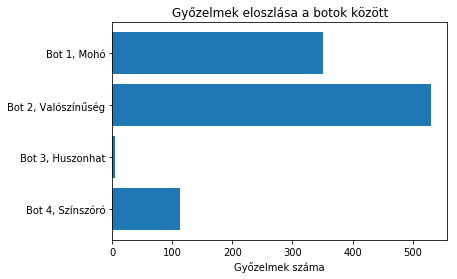

In [12]:
statistics(1000)

In [13]:
# Botok átállítása, újraosztás, újabb statisztika
for bot in bots:
    bot.change_strategy("greedy")

In [14]:
bot1.change_strategy("greedy")
bot2.change_strategy("probability")
bot3.change_strategy("twentysix")
bot4.change_strategy("lesscolors")